## Resolution Enhancement Using Autoencoders
### Import Libraries

In [1]:
import os
import numpy as np
import PIL
import random
import matplotlib.pyplot as plt

np.random.seed(0)

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Read and Visualize Data
Data was downloaded from https://cocodataset.org/#download

In [2]:
# Define Custom Dataset

class ResolutionDataset(tf.keras.utils.Sequence):

  def __init__(self, imgs, batch_size, img_size,train_transform=False):
    
    self.batch_size = batch_size
    self.img_size = img_size
    self.train_transform = train_transform
    self.imgs = imgs

    if self.train_transform:
      # Add preprocessing and data augmentation
      self.my_transform = tf.keras.Sequential([layers.Resizing(img_size[0],img_size[1]),
                                        layers.Rescaling(1./255),
                                        layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.2),
                                        layers.RandomZoom(0.3,0.3),
                                        layers.RandomContrast(0.3)]
                                        )                              
    else:
      # Add preprocessing
      self.my_transform = tf.keras.Sequential([layers.Resizing(img_size, img_size),
                                        layers.Rescaling(1./255)])

  def __len__(self):
    return len(self.imgs) // self.batch_size

  def __getitem__(self, index):

    batch_paths = self.imgs[index * self.batch_size:(index + 1) * self.batch_size]

    # Define high resolution and low resolution batch
    batch_hr_imgs = np.zeros((len(batch_paths),) + self.img_size + (3,), dtype=np.float32)
    batch_lr_imgs = np.zeros((len(batch_paths),) + self.img_size + (3,), dtype=np.float32)

    for i,img_path in enumerate(batch_paths):
      
      # Get high resolution image
      img = np.array(PIL.Image.open(img_path)).astype(np.float32)

      # Convert to 3 channels if grayscale
      if len(img.shape) < 3:
        img = np.stack((img,)*3, axis=-1)

      #  Perform data augmentation
      batch_hr_imgs[i] = self.my_transform(img)

      # Get low resolution image from random rescaling and rescaling to original size
      scale = random.uniform(2, 5)
      down_transform = tf.keras.Sequential([layers.Resizing(int(self.img_size[0]//scale), int(self.img_size[1]//scale)),
                                        layers.Resizing(int(self.img_size[0]), int(self.img_size[1]))])
      batch_lr_imgs[i] = down_transform(batch_hr_imgs[i])

    return batch_hr_imgs,batch_lr_imgs


In [3]:
# Split Data in training and validation set

data_dir = 'data/train'
imgs = [os.path.join(data_dir,img_path) for img_path in os.listdir(data_dir)]
train_imgs, val_imgs = train_test_split(imgs, test_size=0.25, random_state=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


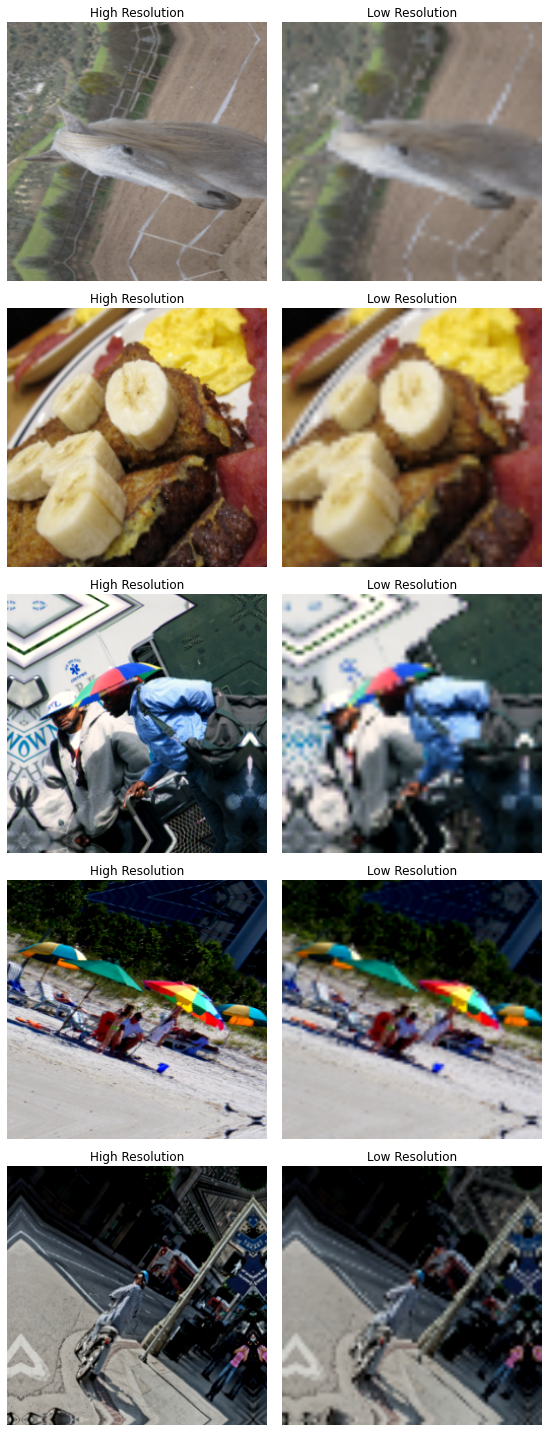

In [4]:
# Visualize 5 images for each class in the dataset

train_gen = ResolutionDataset(train_imgs, 5, (256,256), train_transform=True)
hr_imgs, lr_imgs = next(iter(train_gen))

fig, axs = plt.subplots(5, 2, figsize = (8, 20))

for idx in range(5):
    
    axs[idx][0].title.set_text('High Resolution')
    axs[idx][1].title.set_text('Low Resolution')
    
    axs[idx][0].imshow(hr_imgs[idx])
    axs[idx][1].imshow(lr_imgs[idx])

    axs[idx][0].axis('off')
    axs[idx][1].axis('off')

fig.tight_layout()
plt.show()

### Definition of UNet Architecture 

In [5]:
# Definition of basic block
def conv_block(input, num_filters, ksize, padtype):
  x = Conv2D(num_filters, ksize, padding=padtype)(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(num_filters, ksize, padding=padtype)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def encoder_block(input, num_filters, c_ksize, padtype, p_ksize):
    x = conv_block(input, num_filters, c_ksize, padtype)
    p = MaxPool2D(p_ksize, padding=padtype)(x)
    return x, p

def decoder_block(input, skip_features, num_filters, c_ksize, ct_ksize, st, padtype):
    x = Conv2DTranspose(num_filters, ct_ksize, strides=st, padding=padtype)(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, c_ksize, padtype)
    return x

def unet_model(inputs,out_ch=3,filters=64,levels=4,c_ksize=3,p_ksize=2,ct_ksize=2,st=2,padtype='same'):

    powers = list(range(0,levels))
    bases = [2] * levels
    filters_levels = [filters*(b**p) for b,p in zip(bases,powers)]

    p = inputs
    x_hist = []

    # Encoder Path 
    for idx in range(levels-1):
        x, p = encoder_block(p, filters_levels[idx],c_ksize,padtype,p_ksize)
        x_hist.append(x)

    # Bottleneck
    x = conv_block(p,filters_levels[-1], c_ksize, padtype)

    # Decoder Path
    for idx in reversed(range(0,levels-1)):
        x = decoder_block(x, x_hist[idx], filters_levels[idx], c_ksize, ct_ksize, st, padtype)
    
    outputs = Conv2D(out_ch, 1, padding=padtype, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    return model  

### Network Training

In [8]:
batch_size = 16
num_epochs = 5
img_size = (256,256)

train_gen = ResolutionDataset(train_imgs, batch_size, img_size, train_transform=True)
val_gen = ResolutionDataset(val_imgs, batch_size, img_size, train_transform=True)

hr_imgs, lr_imgs = next(iter(val_gen))

inp_shape = Input(shape=(img_size + (3,)))
model = unet_model(inp_shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics = 'mean_squared_error') 

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
history = model.fit(train_gen, batch_size=batch_size, epochs=num_epochs, validation_data=val_gen, callbacks=[checkpointer])

Epoch 1/5
139/234 [================>.............] - ETA: 11:12 - loss: 0.0048 - mean_squared_error: 0.0048